In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from dataclasses import dataclass
import pathlib

In [190]:
@dataclass(frozen=True)
class DatasetConfig:
    SEED_VALUE:  int = 41
    CUT_PLANE:   str = "sagital"
         
    DATA_ROOT_SOURCE_PATH: str = '/home/jovyan/data/auto-pet-iii/2024-05-10_Autopet_v1.1'
    MAIN_DATA_CSV_PATH: str = DATA_ROOT_SOURCE_PATH + '/fdg_metadata.csv'
    DATA_ROOT_TARGET:  str = f'/home/jovyan/data/segmentation/autopet-min-{CUT_PLANE}' 
    DATA_ROOT_TRAIN:  str = DATA_ROOT_TARGET + '/Train' 
    DATA_ROOT_VALID:  str = DATA_ROOT_TARGET + '/Valid'
    DATA_ROOT_TEST:   str = DATA_ROOT_TARGET + '/Test'
    DATA_TEST_GT:     str = DATA_ROOT_TARGET + '/Test.csv'

In [191]:
# train, val and test split

In [192]:
data_df = pd.read_csv(DatasetConfig.DATA_ROOT_TARGET + "/data_description.csv")
data_df

,Unnamed: 0,Subject ID,Study UID,diagnosis,condition,sliceNum,totalSlices,imagePath,segPath,height,width
0,0,PETCT_f21755a99b,1.3.6.1.4.1.14519.5.2.1.4219.6651.631135993785...,POSITIVE,LYMPHOMA,183,400,/PETCT_f21755a99b-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_f21755a99b-1.3.6.1.4.1.14519.5.2.1.4219...,284,400
1,1,PETCT_605369e88d,1.3.6.1.4.1.14519.5.2.1.4219.6651.161111150372...,POSITIVE,LUNG_CANCER,176,400,/PETCT_605369e88d-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_605369e88d-1.3.6.1.4.1.14519.5.2.1.4219...,326,400
2,2,PETCT_7ce196485f,1.3.6.1.4.1.14519.5.2.1.4219.6651.226902065774...,POSITIVE,MELANOMA,137,400,/PETCT_7ce196485f-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_7ce196485f-1.3.6.1.4.1.14519.5.2.1.4219...,558,400
3,3,PETCT_06a46414eb,1.3.6.1.4.1.14519.5.2.1.4219.6651.346792335378...,POSITIVE,MELANOMA,145,400,/PETCT_06a46414eb-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_06a46414eb-1.3.6.1.4.1.14519.5.2.1.4219...,254,400
4,4,PETCT_380f71df1e,1.3.6.1.4.1.14519.5.2.1.4219.6651.413689396535...,POSITIVE,LUNG_CANCER,198,400,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,326,400
...,...,...,...,...,...,...,...,...,...,...,...
496,496,PETCT_2f7200f771,1.3.6.1.4.1.14519.5.2.1.4219.6651.243768203710...,POSITIVE,MELANOMA,155,400,/PETCT_2f7200f771-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_2f7200f771-1.3.6.1.4.1.14519.5.2.1.4219...,292,400
497,497,PETCT_37472e737f,1.3.6.1.4.1.14519.5.2.1.4219.6651.321569127236...,POSITIVE,LUNG_CANCER,233,400,/PETCT_37472e737f-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_37472e737f-1.3.6.1.4.1.14519.5.2.1.4219...,284,400
498,498,PETCT_aa27cb9156,1.3.6.1.4.1.14519.5.2.1.4219.6651.296549326544...,POSITIVE,LYMPHOMA,192,400,/PETCT_aa27cb9156-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_aa27cb9156-1.3.6.1.4.1.14519.5.2.1.4219...,284,400
499,499,PETCT_80ccbdadf9,1.3.6.1.4.1.14519.5.2.1.4219.6651.478619815683...,POSITIVE,LUNG_CANCER,245,400,/PETCT_80ccbdadf9-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_80ccbdadf9-1.3.6.1.4.1.14519.5.2.1.4219...,326,400


In [193]:
data_df.diagnosis.value_counts()

diagnosis
POSITIVE    501
Name: count, dtype: int64

In [194]:
col_names = data_df.columns.to_list()
col_names[0] = "imageId"
col_names

['imageId',
 'Subject ID',
 'Study UID',
 'diagnosis',
 'condition',
 'sliceNum',
 'totalSlices',
 'imagePath',
 'segPath',
 'height',
 'width']

In [195]:
data_df.columns = col_names
data_df.head()

,imageId,Subject ID,Study UID,diagnosis,condition,sliceNum,totalSlices,imagePath,segPath,height,width
0,0,PETCT_f21755a99b,1.3.6.1.4.1.14519.5.2.1.4219.6651.631135993785...,POSITIVE,LYMPHOMA,183,400,/PETCT_f21755a99b-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_f21755a99b-1.3.6.1.4.1.14519.5.2.1.4219...,284,400
1,1,PETCT_605369e88d,1.3.6.1.4.1.14519.5.2.1.4219.6651.161111150372...,POSITIVE,LUNG_CANCER,176,400,/PETCT_605369e88d-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_605369e88d-1.3.6.1.4.1.14519.5.2.1.4219...,326,400
2,2,PETCT_7ce196485f,1.3.6.1.4.1.14519.5.2.1.4219.6651.226902065774...,POSITIVE,MELANOMA,137,400,/PETCT_7ce196485f-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_7ce196485f-1.3.6.1.4.1.14519.5.2.1.4219...,558,400
3,3,PETCT_06a46414eb,1.3.6.1.4.1.14519.5.2.1.4219.6651.346792335378...,POSITIVE,MELANOMA,145,400,/PETCT_06a46414eb-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_06a46414eb-1.3.6.1.4.1.14519.5.2.1.4219...,254,400
4,4,PETCT_380f71df1e,1.3.6.1.4.1.14519.5.2.1.4219.6651.413689396535...,POSITIVE,LUNG_CANCER,198,400,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,326,400


In [196]:
# new height will be based on the mean value
data_df.height.describe()

count    501.000000
mean     352.606786
std      102.841446
min      242.000000
25%      284.000000
50%      326.000000
75%      326.000000
max      661.000000
Name: height, dtype: float64

In [197]:
data_df[data_df.height > 395]

,imageId,Subject ID,Study UID,diagnosis,condition,sliceNum,totalSlices,imagePath,segPath,height,width
2,2,PETCT_7ce196485f,1.3.6.1.4.1.14519.5.2.1.4219.6651.226902065774...,POSITIVE,MELANOMA,137,400,/PETCT_7ce196485f-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_7ce196485f-1.3.6.1.4.1.14519.5.2.1.4219...,558,400
9,9,PETCT_95efdaba3c,1.3.6.1.4.1.14519.5.2.1.4219.6651.258485171931...,POSITIVE,MELANOMA,218,400,/PETCT_95efdaba3c-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_95efdaba3c-1.3.6.1.4.1.14519.5.2.1.4219...,535,400
26,26,PETCT_a4ff5d0d9d,1.3.6.1.4.1.14519.5.2.1.4219.6651.221723698336...,POSITIVE,LYMPHOMA,181,400,/PETCT_a4ff5d0d9d-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_a4ff5d0d9d-1.3.6.1.4.1.14519.5.2.1.4219...,536,400
30,30,PETCT_d5103c8fbf,1.3.6.1.4.1.14519.5.2.1.4219.6651.300408292929...,POSITIVE,MELANOMA,185,400,/PETCT_d5103c8fbf-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_d5103c8fbf-1.3.6.1.4.1.14519.5.2.1.4219...,470,400
38,38,PETCT_7cfd708a53,1.3.6.1.4.1.14519.5.2.1.4219.6651.103371447020...,POSITIVE,MELANOMA,208,400,/PETCT_7cfd708a53-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_7cfd708a53-1.3.6.1.4.1.14519.5.2.1.4219...,576,400
...,...,...,...,...,...,...,...,...,...,...,...
479,479,PETCT_9521502dbb,1.3.6.1.4.1.14519.5.2.1.4219.6651.310738705514...,POSITIVE,MELANOMA,153,400,/PETCT_9521502dbb-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_9521502dbb-1.3.6.1.4.1.14519.5.2.1.4219...,631,400
481,481,PETCT_a61d8768d0,1.3.6.1.4.1.14519.5.2.1.4219.6651.287991405048...,POSITIVE,MELANOMA,228,400,/PETCT_a61d8768d0-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_a61d8768d0-1.3.6.1.4.1.14519.5.2.1.4219...,577,400
485,485,PETCT_f1ca0f7c4c,1.3.6.1.4.1.14519.5.2.1.4219.6651.185837876796...,POSITIVE,MELANOMA,185,400,/PETCT_f1ca0f7c4c-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_f1ca0f7c4c-1.3.6.1.4.1.14519.5.2.1.4219...,619,400
490,490,PETCT_73597f33fe,1.3.6.1.4.1.14519.5.2.1.4219.6651.211710594549...,POSITIVE,MELANOMA,233,400,/PETCT_73597f33fe-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_73597f33fe-1.3.6.1.4.1.14519.5.2.1.4219...,528,400


In [198]:
data_df[data_df.height <= 395]

,imageId,Subject ID,Study UID,diagnosis,condition,sliceNum,totalSlices,imagePath,segPath,height,width
0,0,PETCT_f21755a99b,1.3.6.1.4.1.14519.5.2.1.4219.6651.631135993785...,POSITIVE,LYMPHOMA,183,400,/PETCT_f21755a99b-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_f21755a99b-1.3.6.1.4.1.14519.5.2.1.4219...,284,400
1,1,PETCT_605369e88d,1.3.6.1.4.1.14519.5.2.1.4219.6651.161111150372...,POSITIVE,LUNG_CANCER,176,400,/PETCT_605369e88d-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_605369e88d-1.3.6.1.4.1.14519.5.2.1.4219...,326,400
3,3,PETCT_06a46414eb,1.3.6.1.4.1.14519.5.2.1.4219.6651.346792335378...,POSITIVE,MELANOMA,145,400,/PETCT_06a46414eb-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_06a46414eb-1.3.6.1.4.1.14519.5.2.1.4219...,254,400
4,4,PETCT_380f71df1e,1.3.6.1.4.1.14519.5.2.1.4219.6651.413689396535...,POSITIVE,LUNG_CANCER,198,400,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,326,400
5,5,PETCT_61348439bf,1.3.6.1.4.1.14519.5.2.1.4219.6651.225609493580...,POSITIVE,LYMPHOMA,190,400,/PETCT_61348439bf-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_61348439bf-1.3.6.1.4.1.14519.5.2.1.4219...,332,400
...,...,...,...,...,...,...,...,...,...,...,...
496,496,PETCT_2f7200f771,1.3.6.1.4.1.14519.5.2.1.4219.6651.243768203710...,POSITIVE,MELANOMA,155,400,/PETCT_2f7200f771-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_2f7200f771-1.3.6.1.4.1.14519.5.2.1.4219...,292,400
497,497,PETCT_37472e737f,1.3.6.1.4.1.14519.5.2.1.4219.6651.321569127236...,POSITIVE,LUNG_CANCER,233,400,/PETCT_37472e737f-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_37472e737f-1.3.6.1.4.1.14519.5.2.1.4219...,284,400
498,498,PETCT_aa27cb9156,1.3.6.1.4.1.14519.5.2.1.4219.6651.296549326544...,POSITIVE,LYMPHOMA,192,400,/PETCT_aa27cb9156-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_aa27cb9156-1.3.6.1.4.1.14519.5.2.1.4219...,284,400
499,499,PETCT_80ccbdadf9,1.3.6.1.4.1.14519.5.2.1.4219.6651.478619815683...,POSITIVE,LUNG_CANCER,245,400,/PETCT_80ccbdadf9-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_80ccbdadf9-1.3.6.1.4.1.14519.5.2.1.4219...,326,400


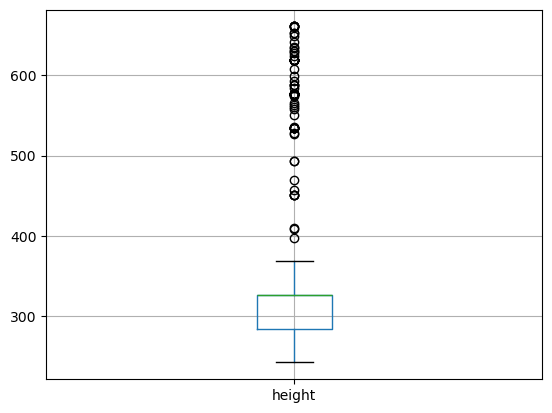

In [199]:
data_df.boxplot(column=["height"])
plt.show()

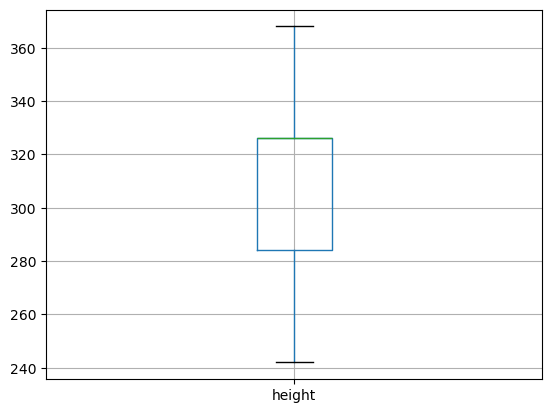

In [200]:
data_df[data_df.height <= 395].boxplot(column=["height"])
plt.show()

In [201]:
data_df[data_df.height <= 395].height.max()

368

In [202]:
data_df.condition.value_counts()

condition
MELANOMA       188
LUNG_CANCER    168
LYMPHOMA       145
Name: count, dtype: int64

In [203]:
# verify distribution of conditions with this filter applied
data_df[data_df.height <= 395].condition.value_counts()

condition
LUNG_CANCER    168
LYMPHOMA       139
MELANOMA       113
Name: count, dtype: int64

In [204]:
# keep original df and filter the data_df
original_df = data_df.copy()
data_df = data_df[data_df.height <= 395].copy()

# Split and Export Images

In [205]:
@dataclass(frozen=True)
class ImageResizeConfig:
    height: int = 368
    width: int = 400

In [206]:
def pre_process_and_export_record(row, is_segmentation=False):
    image_path = DatasetConfig.DATA_ROOT_TARGET + (row["segPath"] if is_segmentation else row["imagePath"])
    img = cv2.imread(image_path)
    img = cv2.resize(img, (ImageResizeConfig.height, ImageResizeConfig.width))
    img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    img_modality = "SEG" if is_segmentation else "PET"
    
    destination_path = f"{DatasetConfig.DATA_ROOT_TARGET}/{row.subset}/{img_modality}"
    pathlib.Path(destination_path).mkdir(parents=True, exist_ok=True)
    destination_path = f"{destination_path}/{row.imageId}.png"
    
    cv2.imwrite(destination_path,img)

In [207]:
data_df["subset"] = None

In [208]:
data_df.head()

,imageId,Subject ID,Study UID,diagnosis,condition,sliceNum,totalSlices,imagePath,segPath,height,width,subset
0,0,PETCT_f21755a99b,1.3.6.1.4.1.14519.5.2.1.4219.6651.631135993785...,POSITIVE,LYMPHOMA,183,400,/PETCT_f21755a99b-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_f21755a99b-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,None
1,1,PETCT_605369e88d,1.3.6.1.4.1.14519.5.2.1.4219.6651.161111150372...,POSITIVE,LUNG_CANCER,176,400,/PETCT_605369e88d-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_605369e88d-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,None
3,3,PETCT_06a46414eb,1.3.6.1.4.1.14519.5.2.1.4219.6651.346792335378...,POSITIVE,MELANOMA,145,400,/PETCT_06a46414eb-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_06a46414eb-1.3.6.1.4.1.14519.5.2.1.4219...,254,400,None
4,4,PETCT_380f71df1e,1.3.6.1.4.1.14519.5.2.1.4219.6651.413689396535...,POSITIVE,LUNG_CANCER,198,400,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,None
5,5,PETCT_61348439bf,1.3.6.1.4.1.14519.5.2.1.4219.6651.225609493580...,POSITIVE,LYMPHOMA,190,400,/PETCT_61348439bf-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_61348439bf-1.3.6.1.4.1.14519.5.2.1.4219...,332,400,None


In [209]:
data_df.condition.value_counts()

condition
LUNG_CANCER    168
LYMPHOMA       139
MELANOMA       113
Name: count, dtype: int64

In [210]:
# split needs to take into account the condition of patient
train_df = pd.concat([
            data_df[data_df.condition == "LUNG_CANCER"].sample(frac=0.8, random_state=DatasetConfig.SEED_VALUE),
            data_df[data_df.condition == "LYMPHOMA"].sample(frac=0.8, random_state=DatasetConfig.SEED_VALUE),
            data_df[data_df.condition == "MELANOMA"].sample(frac=0.8, random_state=DatasetConfig.SEED_VALUE)
        ]).sample(frac=1, random_state=DatasetConfig.SEED_VALUE)
train_df

,imageId,Subject ID,Study UID,diagnosis,condition,sliceNum,totalSlices,imagePath,segPath,height,width,subset
67,67,PETCT_5c1baad5d8,1.3.6.1.4.1.14519.5.2.1.4219.6651.122258061629...,POSITIVE,MELANOMA,196,400,/PETCT_5c1baad5d8-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_5c1baad5d8-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,None
500,500,PETCT_3ba0277c0c,1.3.6.1.4.1.14519.5.2.1.4219.6651.146051428537...,POSITIVE,MELANOMA,272,400,/PETCT_3ba0277c0c-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_3ba0277c0c-1.3.6.1.4.1.14519.5.2.1.4219...,308,400,None
109,109,PETCT_99a7bfad23,1.3.6.1.4.1.14519.5.2.1.4219.6651.286260773849...,POSITIVE,LUNG_CANCER,186,400,/PETCT_99a7bfad23-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_99a7bfad23-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,None
394,394,PETCT_3b73c2480a,1.3.6.1.4.1.14519.5.2.1.4219.6651.299202672052...,POSITIVE,LUNG_CANCER,180,400,/PETCT_3b73c2480a-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_3b73c2480a-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,None
398,398,PETCT_92c5c944a5,1.3.6.1.4.1.14519.5.2.1.4219.6651.106058820536...,POSITIVE,LUNG_CANCER,181,400,/PETCT_92c5c944a5-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_92c5c944a5-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,None
...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,PETCT_d6de1252d9,1.3.6.1.4.1.14519.5.2.1.4219.6651.429161192325...,POSITIVE,MELANOMA,189,400,/PETCT_d6de1252d9-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_d6de1252d9-1.3.6.1.4.1.14519.5.2.1.4219...,338,400,None
367,367,PETCT_7948aa0e26,1.3.6.1.4.1.14519.5.2.1.4219.6651.197581285241...,POSITIVE,LUNG_CANCER,178,400,/PETCT_7948aa0e26-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_7948aa0e26-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,None
5,5,PETCT_61348439bf,1.3.6.1.4.1.14519.5.2.1.4219.6651.225609493580...,POSITIVE,LYMPHOMA,190,400,/PETCT_61348439bf-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_61348439bf-1.3.6.1.4.1.14519.5.2.1.4219...,332,400,None
351,351,PETCT_dc6174cb5d,1.3.6.1.4.1.14519.5.2.1.4219.6651.421237596936...,POSITIVE,MELANOMA,147,400,/PETCT_dc6174cb5d-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_dc6174cb5d-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,None


In [211]:
test_df = data_df.drop(train_df.index, inplace=False).sample(frac=1, random_state=DatasetConfig.SEED_VALUE)
test_df

,imageId,Subject ID,Study UID,diagnosis,condition,sliceNum,totalSlices,imagePath,segPath,height,width,subset
433,433,PETCT_ca47fe5e7d,1.3.6.1.4.1.14519.5.2.1.4219.6651.184188057439...,POSITIVE,LYMPHOMA,211,400,/PETCT_ca47fe5e7d-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_ca47fe5e7d-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,None
190,190,PETCT_8a52353a72,1.3.6.1.4.1.14519.5.2.1.4219.6651.155503527674...,POSITIVE,LYMPHOMA,195,400,/PETCT_8a52353a72-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_8a52353a72-1.3.6.1.4.1.14519.5.2.1.4219...,368,400,None
392,392,PETCT_32aa845af1,1.3.6.1.4.1.14519.5.2.1.4219.6651.235823331598...,POSITIVE,MELANOMA,234,400,/PETCT_32aa845af1-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_32aa845af1-1.3.6.1.4.1.14519.5.2.1.4219...,318,400,None
393,393,PETCT_5d553bf6b4,1.3.6.1.4.1.14519.5.2.1.4219.6651.256689426542...,POSITIVE,LUNG_CANCER,179,400,/PETCT_5d553bf6b4-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_5d553bf6b4-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,None
232,232,PETCT_86153b2974,1.3.6.1.4.1.14519.5.2.1.4219.6651.131129104566...,POSITIVE,MELANOMA,253,400,/PETCT_86153b2974-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_86153b2974-1.3.6.1.4.1.14519.5.2.1.4219...,368,400,None
...,...,...,...,...,...,...,...,...,...,...,...,...
383,383,PETCT_7147385005,1.3.6.1.4.1.14519.5.2.1.4219.6651.758204835564...,POSITIVE,LYMPHOMA,184,400,/PETCT_7147385005-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_7147385005-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,None
453,453,PETCT_04606080a0,1.3.6.1.4.1.14519.5.2.1.4219.6651.115931952100...,POSITIVE,LUNG_CANCER,189,400,/PETCT_04606080a0-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_04606080a0-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,None
86,86,PETCT_d4112bc7ba,1.3.6.1.4.1.14519.5.2.1.4219.6651.154769693254...,POSITIVE,LUNG_CANCER,170,400,/PETCT_d4112bc7ba-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_d4112bc7ba-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,None
254,254,PETCT_0b98dbe00d,1.3.6.1.4.1.14519.5.2.1.4219.6651.436692392257...,POSITIVE,LUNG_CANCER,176,400,/PETCT_0b98dbe00d-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_0b98dbe00d-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,None


In [212]:
# val_df = pd.concat([
#             train_df[train_df.condition == "LUNG_CANCER"].sample(frac=0.1, random_state=DatasetConfig.SEED_VALUE),
#             train_df[train_df.condition == "LYMPHOMA"].sample(frac=0.1, random_state=DatasetConfig.SEED_VALUE),
#             train_df[train_df.condition == "MELANOMA"].sample(frac=0.1, random_state=DatasetConfig.SEED_VALUE)
#         ]).sample(frac=1, random_state=DatasetConfig.SEED_VALUE)
# val_df

In [213]:
# train_df = train_df.drop(val_df.index, inplace=False)
# train_df

In [214]:
train_df.condition.value_counts()

condition
LUNG_CANCER    134
LYMPHOMA       111
MELANOMA        90
Name: count, dtype: int64

In [215]:
# val_df.diagnosis.value_counts()

In [216]:
test_df.condition.value_counts()

condition
LUNG_CANCER    34
LYMPHOMA       28
MELANOMA       23
Name: count, dtype: int64

In [217]:
train_df.subset = "Train"
# val_df.subset = "Valid"
test_df.subset = "Test"

In [218]:
# full_data = pd.concat([train_df, val_df, test_df]).sample(frac=1,random_state=DatasetConfig.SEED_VALUE)
full_data = pd.concat([train_df, test_df]).sample(frac=1,random_state=DatasetConfig.SEED_VALUE)
full_data

,imageId,Subject ID,Study UID,diagnosis,condition,sliceNum,totalSlices,imagePath,segPath,height,width,subset
336,336,PETCT_e04b7fa860,1.3.6.1.4.1.14519.5.2.1.4219.6651.108460079188...,POSITIVE,LUNG_CANCER,253,400,/PETCT_e04b7fa860-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_e04b7fa860-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,Train
421,421,PETCT_ec581d49ef,1.3.6.1.4.1.14519.5.2.1.4219.6651.254007251833...,POSITIVE,MELANOMA,195,400,/PETCT_ec581d49ef-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_ec581d49ef-1.3.6.1.4.1.14519.5.2.1.4219...,368,400,Train
212,212,PETCT_581fa95eb0,1.3.6.1.4.1.14519.5.2.1.4219.6651.417489576678...,POSITIVE,MELANOMA,221,400,/PETCT_581fa95eb0-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_581fa95eb0-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,Train
22,22,PETCT_f1501b1f45,1.3.6.1.4.1.14519.5.2.1.4219.6651.429612488856...,POSITIVE,LYMPHOMA,172,400,/PETCT_f1501b1f45-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_f1501b1f45-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,Train
377,377,PETCT_8aa48809ea,1.3.6.1.4.1.14519.5.2.1.4219.6651.203162846422...,POSITIVE,LUNG_CANCER,187,400,/PETCT_8aa48809ea-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_8aa48809ea-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,Train
...,...,...,...,...,...,...,...,...,...,...,...,...
249,249,PETCT_9f7c68f5ca,1.3.6.1.4.1.14519.5.2.1.4219.6651.278029418516...,POSITIVE,MELANOMA,170,400,/PETCT_9f7c68f5ca-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_9f7c68f5ca-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,Train
430,430,PETCT_901573a747,1.3.6.1.4.1.14519.5.2.1.4219.6651.235730062547...,POSITIVE,LYMPHOMA,230,400,/PETCT_901573a747-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_901573a747-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,Train
4,4,PETCT_380f71df1e,1.3.6.1.4.1.14519.5.2.1.4219.6651.413689396535...,POSITIVE,LUNG_CANCER,198,400,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_380f71df1e-1.3.6.1.4.1.14519.5.2.1.4219...,326,400,Train
229,229,PETCT_63508c679d,1.3.6.1.4.1.14519.5.2.1.4219.6651.288838167058...,POSITIVE,LYMPHOMA,233,400,/PETCT_63508c679d-1.3.6.1.4.1.14519.5.2.1.4219...,/PETCT_63508c679d-1.3.6.1.4.1.14519.5.2.1.4219...,284,400,Test


In [219]:
from tqdm import tqdm

In [220]:
for index, row in tqdm(full_data.iterrows(), total=len(full_data)):
    pre_process_and_export_record(row)
    pre_process_and_export_record(row, True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:01<00:00, 254.58it/s]
